In [15]:
import os

assert os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] == "true"
assert os.environ["CUDA_DEVICE_ORDER"] == "PCI_BUS_ID"
assert os.environ["CUDA_VISIBLE_DEVICES"]

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_hub as tf_hub
from pathlib import Path
from sklearn.model_selection import train_test_split

In [17]:
GPU_BUS_ID = 1
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
PREPROCESS_SEED = 123

In [18]:
base_data_dir = Path("..", "..", "input", "arch-recognizer-dataset").absolute()
train_data_dir = base_data_dir / "train"
test_data_dir = base_data_dir / "test"

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="int",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
class_names = train_ds.class_names
train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_ds = (
    val_ds.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_ds = (
    val_ds.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Found 9101 files belonging to 25 classes.
Using 7281 files for training.
Found 9101 files belonging to 25 classes.
Using 1820 files for validation.
Found 1012 files belonging to 25 classes.


In [20]:
def create_model():
    _model = tf.keras.models.Sequential(
        [
            tf.keras.layers.experimental.preprocessing.RandomFlip(
                "horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
            ),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
            tf.keras.layers.experimental.preprocessing.Rescaling(
                1.0 / 255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
            ),
            tf_hub.KerasLayer(
                "https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1",
                trainable=False,
            ),
            tf.keras.layers.Dense(len(class_names)),
        ]
    )
    _model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return _model

In [21]:
# Create a callback that saves the model's weights periodically
cp_dir = Path("checkpoints")
cp_path = cp_dir / "cp-{epoch:04d}.ckpt"
model = create_model()

# Load checkpoint if found
latest_cp = tf.train.latest_checkpoint(cp_dir)
if latest_cp:
    model.load_weights(latest_cp)
    restored_test_loss, restored_test_acc = model.evaluate(test_ds, verbose=2)
    print(f"Restored model test accuracy: {restored_test_acc}")
    
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(cp_path),
            verbose=1,
            save_weights_only=True,
            save_freq=BATCH_SIZE,
        ),
        tf.keras.callbacks.EarlyStopping(
            min_delta=0.0001, patience=10, restore_best_weights=True
        ),
    ],
)


15/15 - 20s - loss: 1.1197 - accuracy: 0.6396
Restored model test accuracy: 0.6395604610443115
Epoch 1/80
57/57 [==============================] - 88s 1s/step - loss: 1.0976 - accuracy: 0.6838 - val_loss: 1.1004 - val_accuracy: 0.6484
Epoch 2/80
57/57 [==============================] - 64s 1s/step - loss: 1.0756 - accuracy: 0.6892 - val_loss: 1.0874 - val_accuracy: 0.6533
Epoch 3/80
14/57 [======>.......................] - ETA: 38s - loss: 1.0332 - accuracy: 0.7023
Epoch 00003: saving model to distill_bit_r50x1_224_feature_extraction-plain\cp-0003.ckpt
57/57 [==============================] - 65s 1s/step - loss: 1.0416 - accuracy: 0.7007 - val_loss: 1.0729 - val_accuracy: 0.6593
Epoch 4/80
57/57 [==============================] - 64s 1s/step - loss: 1.0233 - accuracy: 0.6999 - val_loss: 1.0600 - val_accuracy: 0.6588
Epoch 5/80
28/57 [=============>................] - ETA: 26s - loss: 0.9922 - accuracy: 0.7120
Epoch 00005: saving model to distill_bit_r50x1_224_feature_extraction-plain\c

In [25]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 13s 842ms/step - loss: 0.9441 - accuracy: 0.7060
Test Loss: 0.9441371560096741
Test Accuracy: 0.7060439586639404


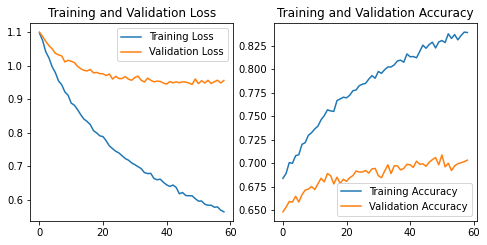

In [34]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
val_loss_range = range(len(loss))

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

(-0.5, 389.5, 279.5, -0.5)

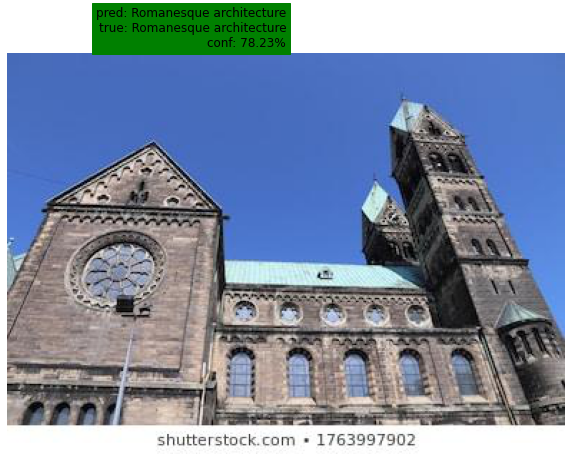

In [45]:
import random

test_files = [
    os.path.join(path, filename)
    for path, _, files in os.walk(test_data_dir)
    for filename in files
    if filename.lower().endswith(".jpg")
]
img_path = Path(random.choice(test_files))

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

pred_y = class_names[np.argmax(score)]
true_y = img_path.parent.stem

plt.figure(figsize=(10, 10))
plt.title(
    f"pred: {pred_y}"
    f"\ntrue: {true_y}"
    f"\nconf: {100 * np.max(score):.2f}%",
    backgroundcolor="green" if pred_y == true_y else "red",
    horizontalalignment='right'
)
plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
plt.axis("off")